Name: Alireza Dehghanpour

Student Number: 98101555


In [1]:
#dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
#load the input image
def load_img(image_name):
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    img = np.asarray(img, dtype="int32")
    image_pixels = np.reshape(img, (-1, img.shape[2]))
    return image_pixels, img.shape

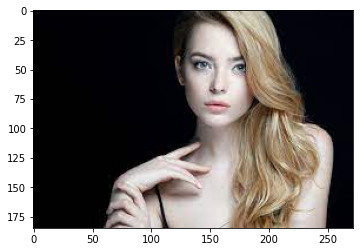

In [3]:
#write the name of your image here
image_name = 'example.jpg'
image_pixels, img_shape = load_img(image_name)

In [4]:
#determine number of desired classes here:

#we can test with diffrent number of K
number_of_classes = 3

In [5]:
#Color each segment of your image. Add your desired colors in RGB format here, as an example:
#here number of desired classes for image segmentation is 3
colors = [
        (255, 0, 0),    # red
        (0, 255, 0),    # green
        (0, 0, 255),    # blue
        # ...
    ]

In [6]:
#for better results, do the initializations with Kmeans 

from sklearn.cluster import KMeans
def kmeans(number_of_classes, image_pixels):

    kmeans = KMeans(n_clusters=number_of_classes)
    clusters = kmeans.fit_predict(image_pixels)

    #choosing clusters center as mean
    initial_mus = kmeans.cluster_centers_
    initial_priors = np.zeros(number_of_classes)
    initial_covs = np.zeros((number_of_classes,3,3))
    
    #calculating priors and covariance
    for i in range(number_of_classes):
      initial_priors[i] = np.count_nonzero(clusters==i)/len(clusters)
      class_colors = np.array([image_pixels[x,:] for x in range(len(clusters)) if clusters[x]==i])
      initial_covs[i,:] = np.cov(class_colors.T)
    res = clusters.reshape(img_shape[0],img_shape[1])

    plt.imshow(res)
    plt.title("with k-means")
    
    return initial_mus, initial_priors, initial_covs

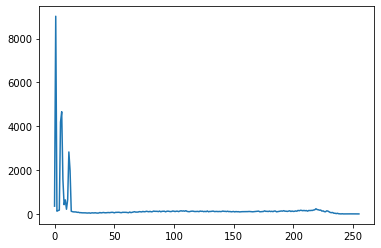

In [7]:
#for better results, observe the image histogram
# I used k-means for initialization
def get_img_histogram():
  img = cv2.imread('example.jpg')
  histr = cv2.calcHist([img],[0],None,[256],[0,256])
  plt.plot(histr)
  plt.show()

  
get_img_histogram()

In [8]:
from scipy.stats import multivariate_normal

class GMM:
    
    def __init__(self, number_of_classes, initial_mu_s, initial_sigma_s, initial_priors):
        self.ncomp = number_of_classes
        self.mu_s = np.asarray(initial_mu_s)
        self.sigma_s = np.asarray(initial_sigma_s)
        self.priors = np.asarray(initial_priors)
    
    
    # Write E step here
    def inference(self, datas):
        P = np.zeros((self.ncomp,len(datas)))
        for i in range(self.ncomp):
          mu = self.mu_s[i,:]
          sigma = self.sigma_s[i,:,:]
          prior = self.priors[i]
          PNk = multivariate_normal.pdf(datas, mean=mu, cov=sigma)
          Pk = prior * PNk
          P[i,] = Pk
        log_likelihood = np.sum(np.log(np.sum(P.T, axis=1)))
        P = P/np.sum(P,axis=0,keepdims=True)
        return P, log_likelihood

        
        
        
        
    # Write M step here
    def update(self, datas, beliefs):

      Nks = np.sum(beliefs, axis=1)
      for i in range(number_of_classes):
        Nk = Nks[i]
        self.priors[i] = Nk/np.sum(Nks)
  
        self.mu_s[i,:] = np.sum(np.multiply(datas.T ,beliefs[i,:]),axis=1)/Nk

        temp_datas = np.subtract(datas, self.mu_s[i,:]) 
        temp_datas = np.multiply(temp_datas.T ,beliefs[i,:]) @ temp_datas
        self.sigma_s[i,:,:] = temp_datas/Nk




    def fit(self,max_iter,image_pixels):
      last_log_likelihood = 0
      for i in range(max_iter):
          beliefs, log_likelihood = gmm.inference(image_pixels)
          gmm.update(image_pixels, beliefs)
          if last_log_likelihood != 0 and abs(log_likelihood - last_log_likelihood) < 1e-10:
              break
          last_log_likelihood = log_likelihood

      
    def predict(self, image_pixels):
      return self.inference(image_pixels)[0]


      
        

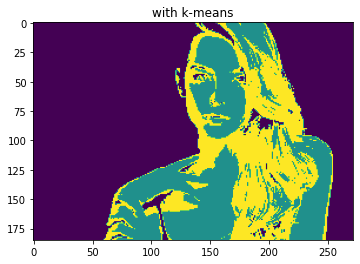

In [9]:
#write your main function here
#use of kmeans or histogram of the image for better initialization is optinal
#call the GMM functions here

#here I find initial parameters with k-means and draw image segmentation with k-means
initial_mus, initial_priors, initial_covs = kmeans(number_of_classes, image_pixels)


gmm = GMM(number_of_classes,initial_mus,initial_covs,initial_priors)

gmm.fit(1000,image_pixels)
labels_prob = gmm.predict(image_pixels)

Text(0.5, 1.0, 'with GMM')

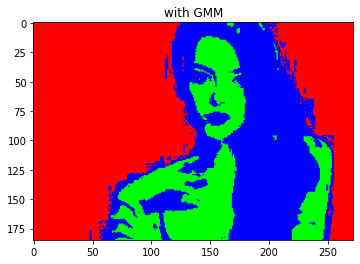

In [10]:
#show and save your results
#let the final image variable be clustered_img
def save_img(clustered_img):
    plt.imshow(clustered_img)
    final_img = cv2.cvtColor(clustered_img.astype('uint8') * 255, cv2.COLOR_RGB2BGR)
    cv2.imwrite("result.jpg", final_img)


picture = np.reshape(labels_prob.T, (img_shape[0],img_shape[1],number_of_classes))
clustered_img = np.zeros((img_shape[0],img_shape[1],3))
for i in range(img_shape[0]):
    for j in range(img_shape[1]):
        label = np.argmax(picture[i, j, :])
        clustered_img[i,j,:] = np.asarray(colors[label]) / 255.0
plt.imshow(clustered_img)
plt.title("with GMM")

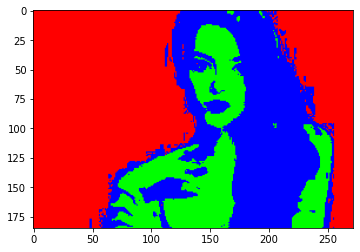

In [11]:
save_img(clustered_img)